In [1]:
## Middleburry 2021 Mobile stereo datasets with ground truth
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import scipy
from tqdm import tqdm
import sys
import time as t

In [2]:
IMG_DIR = 'data/chess1/'
left_imgfile = os.path.join(IMG_DIR, 'im0.png')
right_imgfile = os.path.join(IMG_DIR, 'im1.png')

In [3]:
intrinsic_matrix = np.array([[1758.23, 0, 953.34],
                             [0, 1758.23, 552.29],
                             [0,       0,      1]
                            ])
baseline = 111.53

In [4]:
# gray scale
IMG_SIZE = (int(1920 / 120 * 60), int(1080 /120 * 60))
left_img = cv2.imread(left_imgfile, cv2.IMREAD_GRAYSCALE)
right_img = cv2.imread(right_imgfile, cv2.IMREAD_GRAYSCALE)

# left_img = cv2.resize(left_img, IMG_SIZE)
# right_img = cv2.resize(right_img, IMG_SIZE)


In [5]:
print(left_img.shape)

(1080, 1920)


#### ground truth


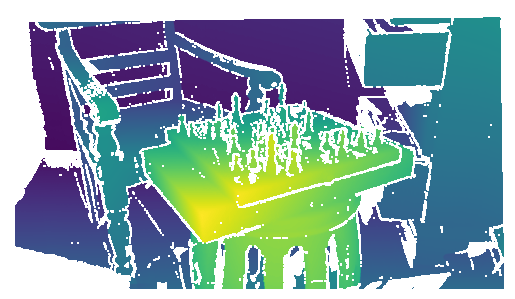

In [6]:

# 파일 확장자 : .pfm
gt_path = 'data/chess1/disp0.pfm'

from pathlib import Path
import numpy as np
import struct

# https://stackoverflow.com/questions/48809433/read-pfm-format-in-python
def read_pfm(filename):
    with Path(filename).open('rb') as pfm_file:

        line1, line2, line3 = (pfm_file.readline().decode('latin-1').strip() for _ in range(3))
        assert line1 in ('PF', 'Pf')
        
        channels = 3 if "PF" in line1 else 1
        width, height = (int(s) for s in line2.split())
        scale_endianess = float(line3)
        bigendian = scale_endianess > 0
        scale = abs(scale_endianess)

        buffer = pfm_file.read()
        samples = width * height * channels
        assert len(buffer) == samples * 4
        
        fmt = f'{"<>"[bigendian]}{samples}f'
        decoded = struct.unpack(fmt, buffer)
        shape = (height, width, 3) if channels == 3 else (height, width)
        return np.flipud(np.reshape(decoded, shape)) * scale


gt = read_pfm(gt_path)
plt.imshow(gt)
plt.axis('off')
plt.show()


In [7]:
def compute_depth_errors(gt, pred) : 

    abs_rel = np.mean(np.abs(gt - pred) / gt)
    sq_rel = np.mean((gt-pred) ** 2 / gt)
    
    rmse = (gt - pred) ** 2
    rmse = np.sqrt(np.mean(rmse))

    rmse_log = (np.log(gt+1e-9) - np.log(pred+1e-9)) ** 2
    rmse_log = np.sqrt(np.mean(rmse_log))

    delta = np.maximum((gt / pred + 1e-9), (pred / gt + 1e-9))
    a1 = (delta < 1.25).mean()
    a2 = (delta < 1.25 ** 2).mean()
    a3 = (delta < 1.25 ** 3).mean()

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

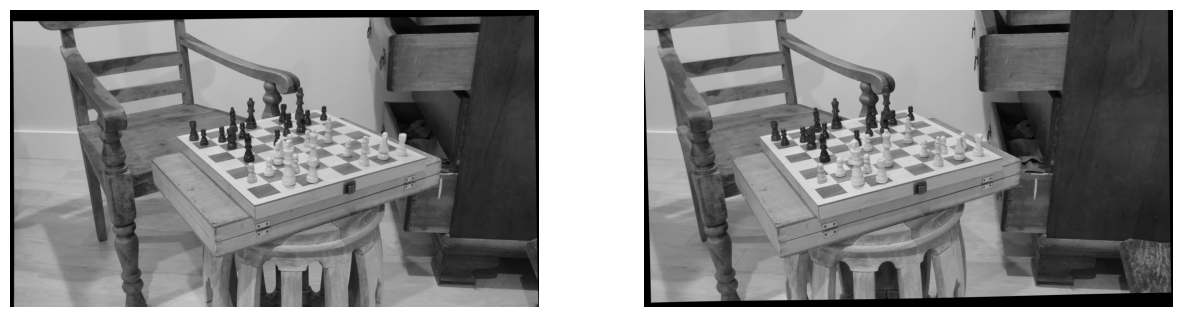

In [8]:
fig, ax = plt.subplots(1,2, figsize = (15, 30))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(left_img, cmap = 'gray')

ax[1].imshow(right_img, cmap = 'gray')

#### Using OpenCV

(-0.5, 1919.5, 1079.5, -0.5)

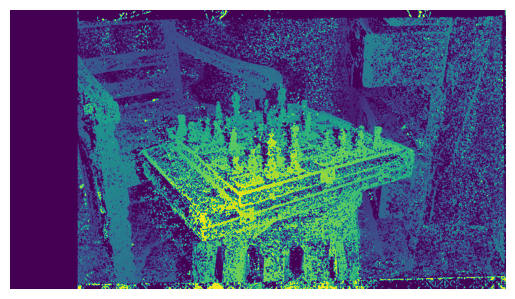

In [9]:
# def onChange(pos) :
#     if pos % 2 == 0 :
#         return pos + 1


# cv2.namedWindow('Trackbar Windows')

# cv2.createTrackbar('minDisparity', 'Trackbar Windows', 0, 30, lambda x : x)
# cv2.createTrackbar('numDisparities', 'Trackbar Windows', 0, 128, lambda x : x)
# cv2.createTrackbar('blocksize', 'Trackbar Windows', 3, 11, onChange)

# cv2.setTrackbarPos('minDisparity', 'Trackbar Windows', 0)
# cv2.setTrackbarPos('numDisparities', 'Trackbar Windows', 32)
# cv2.setTrackbarPos('blocksize', 'Trackbar Windows', 3)

# while cv2.waitKey(1) != ord('q') :
#     minDisparity = cv2.getTrackbarPos('minDisparity', 'Trackbar Windows')
#     numDisparities = cv2.getTrackbarPos('numDisparities', 'Trackbar Windows')
#     blocksize = cv2.getTrackbarPos('blocksize', 'Trackbar Windows')

#     stereo = cv2.StereoSGBM_create(minDisparity = minDisparity, numDisparities = numDisparities, blockSize = blocksize)
#     disparity = stereo.compute(left_img, right_img)

#     cv2.imshow('Trackbar Windows', disparity)


stereo = cv2.StereoSGBM_create(minDisparity = 75, numDisparities = 187, blockSize = 5, speckleWindowSize = 5, speckleRange = 2)
disparity = stereo.compute(left_img, right_img)

# disparity = cv2.normalize(disparity, 0, 255, cv2.NORM_MINMAX)
fx = intrinsic_matrix[0][0]
depth_map = np.uint8((fx*baseline)/ (disparity+1e-6))

plt.imshow(disparity)
plt.axis('off')


In [20]:
disparity = cv2.normalize(disparity, disparity, alpha = 255, beta = 0, norm_type = cv2.NORM_MINMAX)

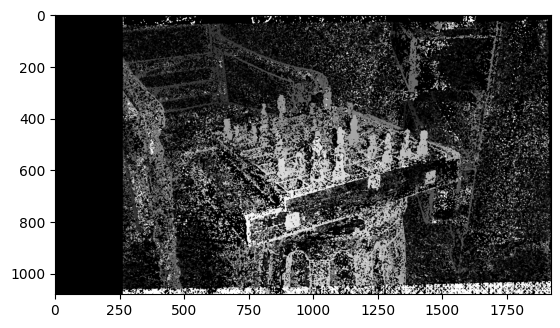

In [21]:
plt.imshow(disparity, cmap = 'gray')

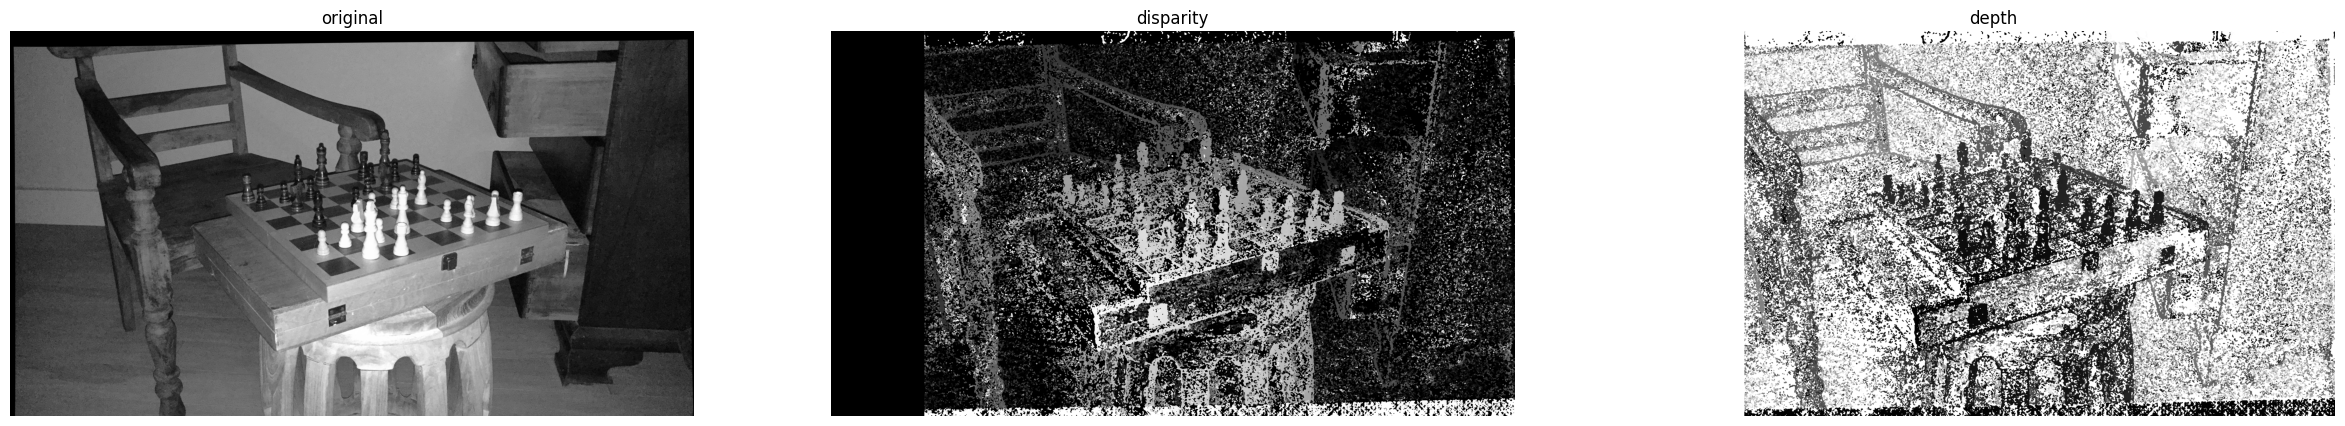

In [22]:
fig, ax = plt.subplots(1,3, figsize = (30, 90))
ax[0].axis('off')
ax[0].set_title('original')
ax[1].axis('off')
ax[1].set_title('disparity')
ax[2].axis('off')
ax[2].set_title('depth')

ax[0].imshow(left_img, cmap = 'gray')
ax[1].imshow(disparity, cmap = 'gray')
ax[2].imshow(depth_map, cmap = 'gray')

In [23]:
## min max normalization

def minmax_normalize(arr) :
    return (arr - arr.min()) / (arr.max() - arr.min())

normalized_disparity = minmax_normalize(disparity)


In [ ]:

mask = gt != np.Inf


abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3 = compute_depth_errors(gt[mask], normalized_disparity[mask])

print(f'Absolute Relative Error : {abs_rel}')
print(f'Square Relative Error : {sq_rel}')
print(f'Root Mean Square Error : {rmse}')
print(f'Root Mean Square Error Log : {rmse_log}')
print(f'Accuracy under threshold(delta=1.25) : {a1}')
print(f'Accuracy under threshold(delta=1.56) : {a2}')
print(f'Accuracy under threshold(delta=1.95) : {a3}')

0.6666666666666666

In [122]:

# pred


2073600


1767536

#### Delve into

- naive brute force
- semi-global matching
- Deep Learning Based Approach : Google HitNet

#### Naive Brute Force

<div>
<img src='triangulation_stereo_vision.jpg' width = '400'>
</div>

- y축이 고정되어있을 때, 물체의 3D 좌표 중 Z축(깊이; 카메라로부터의 거리)은 왼쪽 카메라에서의 물체의 x좌표와 오른쪽 카메라에서의 x좌표 차이(disparity)와 **반비례**하다. ( $z$ = $b$ $f_{x}$ / ($u_{l}$-$u_{r}$) )
- disparity를 찾은 후, depth map을 계산하는 문제로 치환가능하다.
- disparity를 찾는 것은, 동일한 y선상에서 왼쪽과 오른쪽 이미지에 일치하는 픽셀값을 찾아내는 것과 같다.


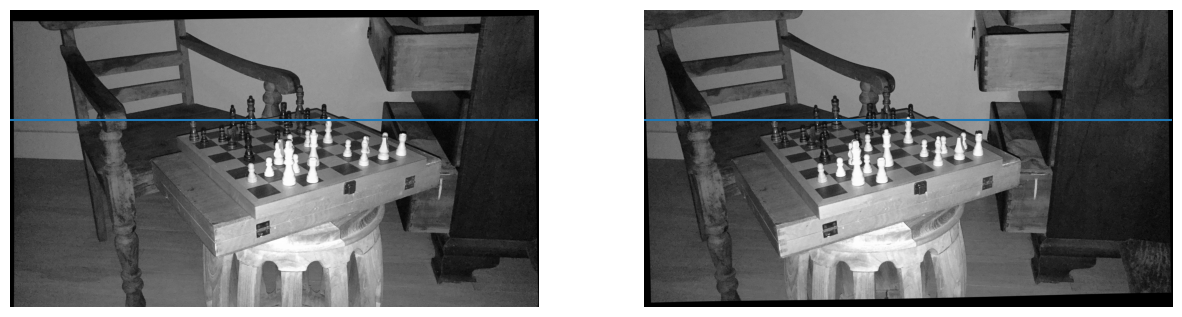

In [23]:
fig, ax = plt.subplots(1,2, figsize = (15, 30))
ax[0].axis('off')
ax[1].axis('off')
ax[0].imshow(cv2.cvtColor(left_img, cv2.COLOR_GRAY2RGB), cmap = 'gray')

ax[1].imshow(cv2.cvtColor(right_img, cv2.COLOR_GRAY2RGB), cmap = 'gray')
ax[0].axhline(400)
ax[1].axhline(400)

In [24]:

# 1.SAD
# 2. BINCHFIELD-TOMASI
# census transform

In [25]:
640 * 1080

691200

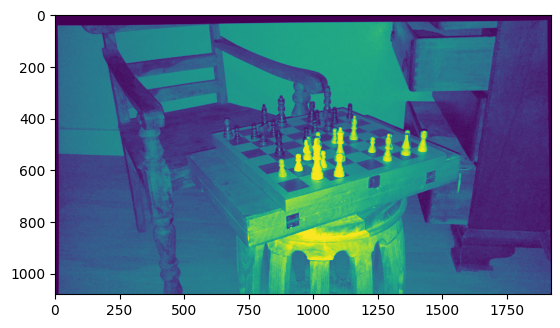

In [26]:
plt.imshow(left_img)

In [10]:
def capture_window(img, img_h, img_w, window_size, row_idx, col_idx) : 
    assert window_size % 2, "let's keep the window size odd."
    k = (window_size - 1) // 2

    window = np.zeros((window_size, window_size), dtype = np.uint8)
    min_h, max_h = max(0, row_idx - k), min(img_h, row_idx + k + 1)
    min_w, max_w = max(0, col_idx - k), min(img_w, col_idx + k + 1)
    window[min_h - (row_idx - k) : max_h - (row_idx + k + 1) + window_size,
                min_w - (col_idx - k) : max_w - (col_idx + k + 1) + window_size] = img[min_h : max_h, min_w : max_w]

    return window

In [11]:
def calculate_diff(src, trg, method = 'SAD') :
    '''
    SAD : sum of absolute difference
    SSD : sum of squared difference
    NCC : Maximum normalized cross-correlation
    '''
    if method == 'SAD' :
        ## sum of absolute difference
        return np.sum(np.absolute(src - trg))

    elif method == 'SSD' :
        ## sum of squared distance
        return np.sum(np.square(src - trg))

    elif method == 'NCC' :
        ## maximum normalized cross-correlation
       
        return np.sum(src*trg / np.sqrt(np.sum(np.square(src)) * np.sum(np.square(trg)))+1e-8 )

In [32]:
src = np.array([[1,1,0],
                [0,0,0],
                [0,0,0]
])

trg = np.array([[1,1,0.0],
                [0,0,0],
                [0.0,0.,0.0]
])

trg = src
# trg = np.array([[0,0,0],
#                 [1,1,1],
#                 [0,0,0]
# ])

calculate_diff(src, trg, method = 'NCC')

1.0000000900000001

In [34]:
# # row by row
# diff_arr = np.zeros((H, W, W))

# for row_idx in tqdm(range(H), desc = 'row', leave = True) :

#     for col_idx in range(W): 
#         src = capture_window(left_img, H, W, window_size, row_idx, col_idx)
#         for trg_col_idx in range(W): 
#             trg = capture_window(right_img, H, W, window_size, row_idx, trg_col_idx)

#             diff_arr[row_idx, col_idx, trg_col_idx] = calculate_diff(src, trg, method = 'SAD')
            
# np.save('diffarr_SAD.npy', diff_arr, )        


row:  51%|█████     | 46/90 [00:05<00:05,  8.35it/s]


KeyboardInterrupt: 

In [54]:
# row by row
# window_size = 7
# H, W = left_img.shape[:2]

# diff_arr = np.zeros((H, W, W))

# for row_idx in tqdm(range(H), desc = 'row', leave = True) :

#     for col_idx in range(W): 
#         src = capture_window(left_img, H, W, window_size, row_idx, col_idx)
#         for trg_col_idx in range(W): 
#             trg = capture_window(right_img, H, W, window_size, row_idx, trg_col_idx)

#             diff_arr[row_idx, col_idx, trg_col_idx] = calculate_diff(src, trg, method = 'SSD')
            
# np.save('diffarr_SSD.npy', diff_arr, )

row: 100%|██████████| 540/540 [37:58<00:00,  4.22s/it]


In [35]:
# row by row


window_size = 7
H, W = left_img.shape[:2]

ncc_diff_arr = np.zeros((H, W, W), dtype = np.float64)

for row_idx in tqdm(range(H), desc = 'row', leave = True) :

    for col_idx in range(W): 
        src = capture_window(left_img, H, W, window_size, row_idx, col_idx)
        for trg_col_idx in range(W): 
            trg = capture_window(right_img, H, W, window_size, row_idx, trg_col_idx)

            ncc_diff_arr[row_idx, col_idx, trg_col_idx] = calculate_diff(src, trg, method = 'NCC')
            
# np.save('diffarr_NCC.npy', ncc_diff_arr, )

row:   0%|          | 0/90 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_22304\4286489467.py:18: RuntimeWarning: invalid value encountered in divide
  return np.sum(src*trg / np.sqrt(np.sum(np.square(src)) * np.sum(np.square(trg)))+1e-8 )
row: 100%|██████████| 90/90 [00:26<00:00,  3.46it/s]


In [61]:
# gray scale
IMG_SIZE = (int(1920 / 120 * 60), int(1080 /120 * 60))
left_img = cv2.imread(left_imgfile, cv2.IMREAD_GRAYSCALE)
right_img = cv2.imread(right_imgfile, cv2.IMREAD_GRAYSCALE)

left_img = cv2.resize(left_img, IMG_SIZE)
right_img = cv2.resize(right_img, IMG_SIZE)

In [57]:
sad_diff_arr = np.load('diffarr_SAD.npy')
ssd_diff_arr = np.load('diffarr_SSD.npy')
# ncc_diff_arr = np.load('diffarr_NCC.npy')

In [55]:
sad_diff_arr.shape

(540, 960, 960)

In [62]:
sad_argmin_arr = np.argmin(sad_diff_arr, axis = -1)
ssd_argmin_arr = np.argmin(ssd_diff_arr, axis = -1)
ncc_argmin_arr = np.argmin(ncc_diff_arr, axis = -1)

TypeError: Invalid shape (90, 160, 160) for image data

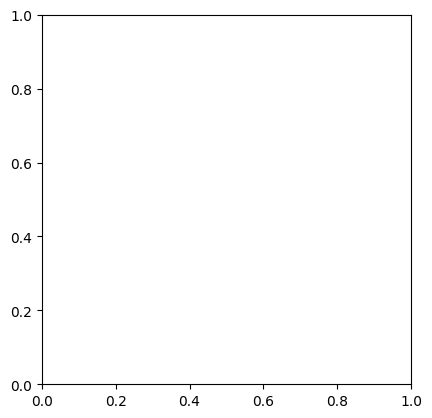

In [47]:
plt.imshow(ncc_diff_arr)

In [63]:
sad_disparity_map = np.zeros(left_img.shape, np.uint8)
for h in range(left_img.shape[0]) :
    for w in range(left_img.shape[1]) :
        if left_img[h,w] :
            sad_disparity_map[h,w] = w - sad_argmin_arr[h,w]

ssd_disparity_map = np.zeros(left_img.shape, np.uint8)
for h in range(left_img.shape[0]) :
    for w in range(left_img.shape[1]) :
        if left_img[h,w] :
            ssd_disparity_map[h,w] = w - ssd_argmin_arr[h,w]

ncc_disparity_map = np.zeros(left_img.shape, np.uint8)
for h in range(left_img.shape[0]) :
    for w in range(left_img.shape[1]) :
        if left_img[h,w] :
            ncc_disparity_map[h,w] = w - ncc_argmin_arr[h,w]


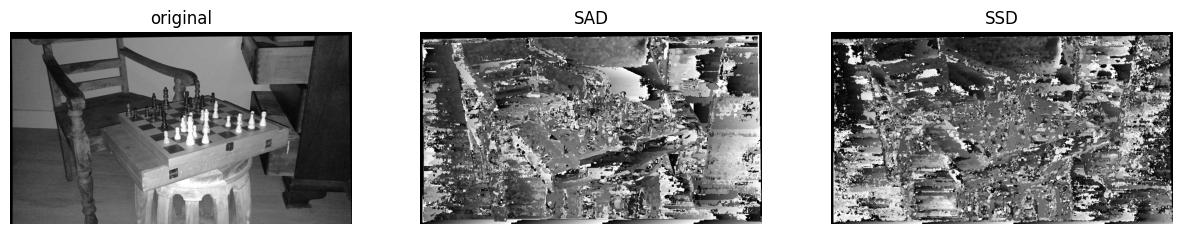

In [67]:
fig, ax = plt.subplots(1,3, figsize = (15, 45))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

ax[0].set_title('original')
ax[1].set_title('SAD')
ax[2].set_title('SSD')
ax[0].imshow(left_img, cmap = 'gray')
ax[1].imshow(sad_disparity_map, cmap = 'gray')
ax[2].imshow(ssd_disparity_map, cmap = 'gray')
# ax[2].imshow(ncc_disparity_map, cmap = 'gray')

In [145]:
resized_sad_disparity_map = cv2.resize(sad_disparity_map, (1920, 1080))
resized_ssd_disparity_map = cv2.resize(ssd_disparity_map, (1920, 1080))


normalized_sad_disparitymap = minmax_normalize(resized_sad_disparity_map)
normalized_ssd_disparitymap = minmax_normalize(resized_ssd_disparity_map)


mask = gt != np.Inf


sad_abs_rel, sad_sq_rel, sad_rmse, sad_rmse_log, sad_a1, sad_a2, sad_a3 = compute_depth_errors(gt[mask], normalized_sad_disparitymap[mask])

ssd_abs_rel, ssd_sq_rel, ssd_rmse, ssd_rmse_log, ssd_a1, ssd_a2, ssd_a3 = compute_depth_errors(gt[mask], normalized_ssd_disparitymap[mask])

print(f'Absolute Relative Error : {sad_abs_rel}')
print(f'Square Relative Error : {sad_sq_rel}')
print(f'Root Mean Square Error : {sad_rmse}')
print(f'Root Mean Square Error Log : {sad_rmse_log}')
print(f'Accuracy under threshold(delta=1.25) : {sad_a1}')
print(f'Accuracy under threshold(delta=1.56) : {sad_a2}')
print(f'Accuracy under threshold(delta=1.95) : {sad_a3}')



print(f'Absolute Relative Error : {ssd_abs_rel}')
print(f'Square Relative Error : {ssd_sq_rel}')
print(f'Root Mean Square Error : {ssd_rmse}')
print(f'Root Mean Square Error Log : {ssd_rmse_log}')
print(f'Accuracy under threshold(delta=1.25) : {ssd_a1}')
print(f'Accuracy under threshold(delta=1.56) : {ssd_a2}')
print(f'Accuracy under threshold(delta=1.95) : {ssd_a3}')


Absolute Relative Error : 0.44503069835360615
Square Relative Error : 0.16262413435924977
Root Mean Square Error : 0.3239238091855173
Root Mean Square Error Log : 0.9994220439574371
Accuracy under threshold(delta=1.25) : 0.24336137990965956
Accuracy under threshold(delta=1.56) : 0.48864181549909025
Accuracy under threshold(delta=1.95) : 0.6719387893655349
Absolute Relative Error : 0.504881367407271
Square Relative Error : 0.1881450206412212
Root Mean Square Error : 0.3407310512921744
Root Mean Square Error Log : 1.1699584808545753
Accuracy under threshold(delta=1.25) : 0.18316402042164912
Accuracy under threshold(delta=1.56) : 0.3690238840962787
Accuracy under threshold(delta=1.95) : 0.5331127626254855


C:\Users\user\AppData\Local\Temp\ipykernel_22304\3757217767.py:12: RuntimeWarning: divide by zero encountered in divide
  delta = np.maximum((gt / pred + 1e-9), (pred / gt + 1e-9))


#### Semi-Global Matching

In [12]:
### census transform

def census_transform(img, H, W, window_size, row_idx, col_idx) :
    
    center_value = img[row_idx, col_idx]
    consensus = np.full((window_size, window_size), fill_value = center_value, dtype = np.int32)
    window = capture_window(img, H, W, window_size, row_idx, col_idx)

    comparison = consensus - window

    diff_bits = np.where(comparison < 0, 1, 0).flatten()
    census_values = diff_bits.dot(1<< np.arange(window_size*window_size)[::-1]) # 이웃들의 위치를 구별하기 위해서 2의 제곱만큼의 값들을 곱해준다. 좌상단 값이 가장 큰 가중치를 갖고, 우하단은 가장 작은 가중치를 갖게된다.

    return census_values




In [14]:
H, W = left_img.shape

left_census = np.zeros(left_img.shape, np.int32)

for row_idx in tqdm(range(H), desc = 'row', leave = True) :
    for col_idx in range(W) :
        left_census[row_idx, col_idx] = census_transform(left_img, H, W, 
                                                         window_size = 3, 
                                                         row_idx = row_idx, 
                                                         col_idx = col_idx)


right_census = np.zeros(right_img.shape, np.int32)

for row_idx in tqdm(range(H), desc = 'row', leave = True) :
    for col_idx in range(W) :
        right_census[row_idx, col_idx] = census_transform(right_img, H, W, 
                                                         window_size = 3, 
                                                         row_idx = row_idx, 
                                                         col_idx = col_idx)


row: 100%|██████████| 1080/1080 [00:16<00:00, 67.07it/s]


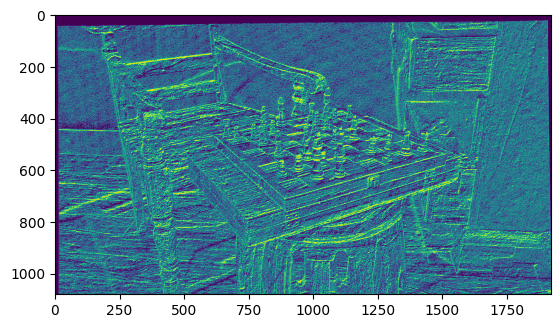

In [47]:
plt.imshow(left_census)

In [34]:
def hamming_distance(arr1, arr2) :
    assert arr1.shape == arr2.shape

    distance = np.zeros(arr1.shape, np.uint32)
    xor = np.int32(np.bitwise_xor(np.int32(arr1), arr2))

    while not np.all(xor == 0) :
        tmp = xor - 1 # 비교값이 다른(xor) 자리수를 하나씩 빼나간다.
        mask = xor != 0 # 0이 된 값은 더 이상 건드리지 않는다.
        xor[mask] = np.bitwise_and(xor[mask], tmp[mask])
        distance[mask] += 1 # cost를 업데이트한다.

    return distance





In [48]:
# calculate hamming distance

max_disparity = 290

left_cost_volume = np.zeros((H,W, max_disparity), dtype = np.uint32)
right_cost_volume = np.zeros((H,W, max_disparity), dtype = np.uint32)

lcensus = np.zeros((H,W), dtype = np.uint32)
rcensus = np.zeros((H,W), dtype = np.uint32)

for d in tqdm(range(max_disparity)) :
    ## 이미지가 rectified되어 y선상이 고정이라는 가정 하에 가능한 연산이다.   
    lcensus[:, : W-d ] = left_census[:, d : W ]
    rcensus[:, d : W ] = right_census[:, : W-d ]

    left_distance = hamming_distance(np.int32(left_census), rcensus)
    right_distance = hamming_distance(np.int32(right_census), lcensus)

    left_cost_volume[:,:,d] = left_distance
    right_cost_volume[:,:,d] = right_distance
    





In [30]:
def normalize(disp, max_disparity) :
    return 255.0 * disp / max_disparity

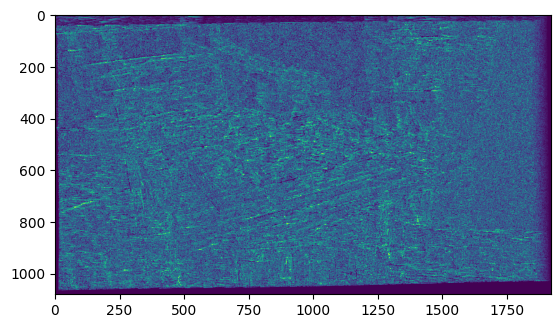

In [28]:
plt.imshow(left_costs)

Text(0.5, 1.0, 'depth')

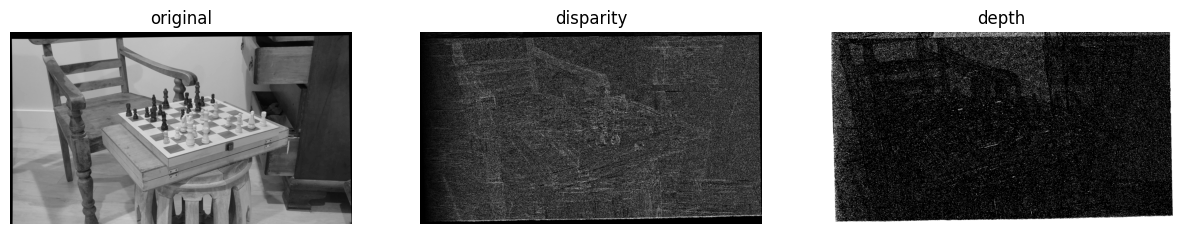

In [58]:
left_costs = np.uint8(normalize(np.argmin(left_cost_volume, axis = 2), max_disparity))
# left_costs = np.argmin(left_cost_volume, axis = 2)

sgm_depthmap = np.uint8(minmax_normalize((fx * baseline)/ (left_costs + 1e-9))*255.)

fig, ax = plt.subplots(1,3, figsize = (15, 45))
ax[0].imshow(left_img, 'gray')
ax[0].axis('off')
ax[0].set_title('original')
ax[1].imshow(left_costs, 'gray')
ax[1].axis('off')
ax[1].set_title('disparity')
ax[2].imshow(sgm_depthmap, 'gray')
ax[2].axis('off')
ax[2].set_title('depth')

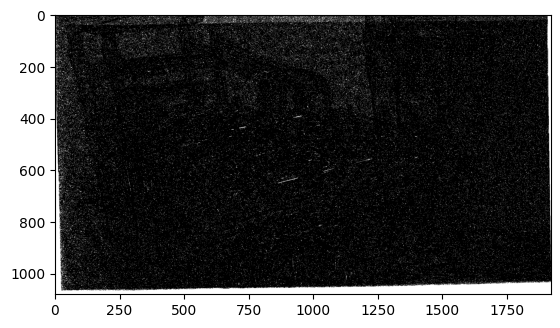

In [57]:


plt.imshow(sgm_depthmap, 'gray')
# plt.imshow(sgm_depthmap)

In [173]:
sgm_disparity_map = minmax_normalize(np.argmin(left_cost_volume, axis = 2))

sgm_abs_rel, sgm_sq_rel, sgm_rmse, sgm_rmse_log, sgm_a1, sgm_a2, sgm_a3 = compute_depth_errors(gt[mask], sgm_disparity_map[mask])

print(f'Absolute Relative Error : {sgm_abs_rel}')
print(f'Square Relative Error : {sgm_sq_rel}')
print(f'Root Mean Square Error : {sgm_rmse}')
print(f'Root Mean Square Error Log : {sgm_rmse_log}')
print(f'Accuracy under threshold(delta=1.25) : {sgm_a1}')
print(f'Accuracy under threshold(delta=1.56) : {sgm_a2}')
print(f'Accuracy under threshold(delta=1.95) : {sgm_a3}')

Absolute Relative Error : 0.6345527587108155
Square Relative Error : 0.29298680076715516
Root Mean Square Error : 0.43319152051366877
Root Mean Square Error Log : 6.185706305150487
Accuracy under threshold(delta=1.25) : 0.14717437155452562
Accuracy under threshold(delta=1.56) : 0.2782975848865313
Accuracy under threshold(delta=1.95) : 0.3907767649428357


C:\Users\user\AppData\Local\Temp\ipykernel_22304\3757217767.py:12: RuntimeWarning: divide by zero encountered in divide
  delta = np.maximum((gt / pred + 1e-9), (pred / gt + 1e-9))


#### Cost Aggregation

In [190]:
other_dim = H
disparity_dim = max_disparity

# north_direction
# south_direction

south_aggregation = np.zeros((H,W,max_disparity), dtype = np.uint32)
north_aggregation = np.zeros((H,W,max_disparity), dtype = np.uint32)
# for x in range(width) :
#     south = left_cost_volume[:, x, :]
#     north = np.flip(south, axis = 0)
#     south_aggregation[:, x, :] 

slice = left_cost_volume[:, 100, :]

minimum_cost_path = np.zeros(shape = (other_dim, disparity_dim), dtype = np.uint32)
minimum_cost_path = slice

for pixel_index in range(other_dim) :

    previous_cost = minimum_cost_path[pixel_index - 1, :]

    current_cost = slice[pixel_index, :]
    costs = np.repeat(previous_cost, repeats = disparity_dim, axis = 0)

    print('current cost : ', current_cost.shape)
    print(costs)
    print(costs.shape)

    break


current cost :  (64,)
[5 5 5 ... 5 5 5]
(4096,)


In [64]:
np.amin(np.array([[5,2,3],
                  [2,3,4]]), axis = 0)

np.array([[5,2,3],[2,3,4]]).shape

(2, 3)

In [38]:
def get_penalties(max_disparity, P2, P1):
    """
    Creates a matrix of all the potential penalties for matching
    a current disparity (represented by the column index), with 
    a previous disparity (represented by the row index).
    Arguments:
        - max_disparity: Maximum disparity of the array.
        - P2: Penalty for disparity difference > 1
        - P1: Penalty for disparity difference = 1
    
    Return: Matrix containing all the penalties when disparity d1 from a column
            is matched with a previous disparity d2 from the row.
    """
    p2 = np.full(shape=(max_disparity, max_disparity), fill_value=P2, dtype=np.uint32)
    p1 = np.full(shape=(max_disparity, max_disparity), fill_value=P1 - P2, dtype=np.uint32)
    p1 = np.tril(p1, k=1) # keep values lower than k'th diagonal
    p1 = np.triu(p1, k=-1) # keep values higher than k'th diagonal
    no_penalty = np.identity(max_disparity, dtype=np.uint32) * -P1 # create diagonal matrix with values -p1
    penalties = p1 + p2 + no_penalty
    return penalties


def get_path_cost(slice, offset, penalties, other_dim, disparity_dim):
    """
    Calculates the minimum costs for all potential disparities of 
    the pixels along a single path direction.
    Arguments:
        - slice: Array containing costs for all disparities, D, 
            along a direction, M, with dimension M x D
        - offset: Number of pixels on the border to ignore.
        - penalties: Matrix containing the penalties to assign to the 
            previous disparities costs. For previous disparities that differ 
            from current disparities. 
        - other_dim: Number of pixels in the current paths direction.
        - disparity_dim: Number of disparities to calculate minimum costs.

    Returns: The pixels minimum costs for all disparities, D, 
        along path direction, M, with shape M x D.
    """
    minimum_cost_path = np.zeros(shape=(other_dim, disparity_dim), dtype=np.uint32)
    minimum_cost_path[offset - 1, :] = slice[offset - 1, :]

    for pixel_index in range(offset, other_dim):
        # Get all the minimum disparities costs from the previous pixel in the path
        previous_cost = minimum_cost_path[pixel_index - 1, :]
        # Get all the disparities costs (from the cost volume) for the current pixel
        current_cost = slice[pixel_index, :]
        costs = np.repeat(previous_cost, repeats=disparity_dim, axis=0).reshape(disparity_dim, disparity_dim)
        # Add penalties to the previous pixels disparities that differ from current pixels disparities
        costs = costs + penalties
        # Find minimum costs for the current pixels disparities using the previous disparities costs + penalties 
        costs = np.amin(costs, axis=0)  
        # Current pixels disparities costs + minimum previous pixel disparities costs (with penalty) - 
        # (constant term) minimum previous cost from all disparities 
        pixel_direction_costs = current_cost + costs - np.amin(previous_cost)
        minimum_cost_path[pixel_index, :] = pixel_direction_costs

    return minimum_cost_path    


def aggregate_costs(cost_volume, P2, P1, height, width, disparities):
    """
    Calculates the pixels costs for all disparities along all paths (4 in this case).

    Arguments: 
        - cost_volume: Array containing the matching cost for each pixel at each disparity.
        - P2: Penalty for disparity difference > 1
        - P1: Penalty for disparity difference = 1
        - height: Number of rows of the image.
        - width: Number of columns of the image.
        - disparities: Number of disparities to calculate minimum matching costs.

    Returns: Array containing the pixels matching costs for all disparities along 
        all directions, with dimension H x W x D X 4.
    """
    sys.stdout.flush()
    dawn = t.time()

    penalties = get_penalties(disparities, P2, P1)

    print("\tProcessing North and South aggregation...")
    south_aggregation = np.zeros(shape=(height, width, disparities), dtype=np.uint32)
    north_aggregation = np.copy(south_aggregation)

    for x in range(0, width):
        # Takes all the rows and disparities for a single column
        south = cost_volume[:, x, :]
        # Invert the rows to get the opposite direction
        north = np.flip(south, axis=0)
        south_aggregation[:, x, :] = get_path_cost(south, 1, penalties, height, disparities)
        north_aggregation[:, x, :] = np.flip(get_path_cost(north, 1, penalties, height, disparities), axis=0)


    print("\tProcessing East and West aggregation...", end='')
    east_aggregation = np.copy(south_aggregation)
    west_aggregation = np.copy(south_aggregation)
    for y in range(0, height):
        # Takes all the column and disparities for a single row
        east = cost_volume[y, :, :]
        # Invert the columns to get the opposite direction
        west = np.flip(east, axis=0)
        east_aggregation[y, :, :] = get_path_cost(east, 1, penalties, width, disparities)
        west_aggregation[y, :, :] = np.flip(get_path_cost(west, 1, penalties, width, disparities), axis=0)

    # Combine the costs from all paths into a single aggregation volume
    aggregation_volume = np.concatenate((south_aggregation[..., None], north_aggregation[..., None], east_aggregation[..., None], west_aggregation[..., None]), axis=3)

    dusk = t.time()
    print('\t(done in {:.2f}s)'.format(dusk - dawn))

    return aggregation_volume

In [39]:
left_aggregation_volume = aggregate_costs(cost_volume = left_cost_volume, P2 = 5, P1 = 2, height = H, width = W, disparities = 64)

	Processing North and South aggregation...
	Processing East and West aggregation...	(done in 134.59s)


In [40]:
def select_disparity(aggregation_volume):
    """
    Converts the aggregation volume into a disparity map using 
    the winner takes all strategy. 
    Cost volume is first calculated by taking the sum of the costs over all paths.
    Then the disparities are determined by finding the 
    disparity index with the lowest cost for the pixel.

    Arguments:
        - aggregation_volume: Array containing the matching costs for 
            all pixels at all disparities and paths, with dimension H x W x D x N

    Returns: Disparity map with dimensions H x W.
    """
    # sum up costs for all directions
    volume = np.sum(aggregation_volume, axis=3) 
    # returns the disparity index with the minimum cost associated with each h x w pixel
    disparity_map = np.argmin(volume, axis=2) 
    return disparity_map

In [255]:
get_penalties(max_disparity, 10, 5)

array([[ 0,  5, 10, ..., 10, 10, 10],
       [ 5,  0,  5, ..., 10, 10, 10],
       [10,  5,  0, ..., 10, 10, 10],
       ...,
       [10, 10, 10, ...,  0,  5, 10],
       [10, 10, 10, ...,  5,  0,  5],
       [10, 10, 10, ..., 10,  5,  0]], dtype=int64)

In [42]:
ca_left_disparity_map = select_disparity(left_aggregation_volume)
# normalized_ca_left_disparity_map = minmax_normalize(left_disparity_map)

In [43]:


ca_abs_rel, ca_sq_rel, ca_rmse, ca_rmse_log, ca_a1, ca_a2, ca_a3 = compute_depth_errors(gt[mask], normalized_left_disparity_map[mask])

print(f'Absolute Relative Error : {ca_abs_rel}')
print(f'Square Relative Error : {ca_sq_rel}')
print(f'Root Mean Square Error : {ca_rmse}')
print(f'Root Mean Square Error Log : {ca_rmse_log}')
print(f'Accuracy under threshold(delta=1.25) : {ca_a1}')
print(f'Accuracy under threshold(delta=1.56) : {ca_a2}')
print(f'Accuracy under threshold(delta=1.95) : {ca_a3}')

NameError: name 'mask' is not defined

Text(0.5, 1.0, 'depth')

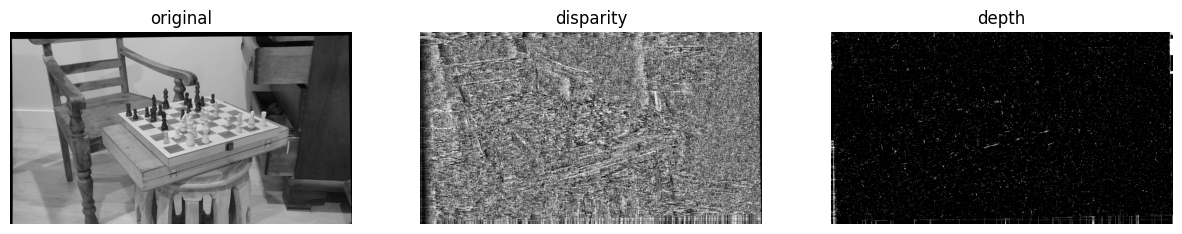

In [45]:
normalized_ca_left_disparity_map = minmax_normalize(ca_left_disparity_map)
ca_depthmap = minmax_normalize((fx * baseline)/ (normalized_ca_left_disparity_map + 1e-9))

fig, ax = plt.subplots(1,3, figsize = (15, 45))
ax[0].imshow(left_img, 'gray')
ax[0].axis('off')
ax[0].set_title('original')
ax[1].imshow(normalized_ca_left_disparity_map, 'gray')
ax[1].axis('off')
ax[1].set_title('disparity')
ax[2].imshow(ca_depthmap, 'gray')
ax[2].axis('off')
ax[2].set_title('depth')


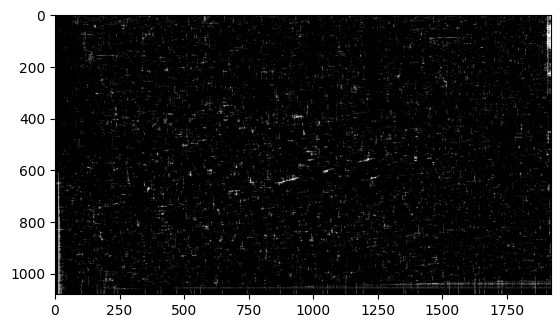

#### 이미지를 통해서 projection matrix를 구해야한다고 하면?

In [22]:
sift = cv2.SIFT_create()
left_kp, left_des = sift.detectAndCompute(left_img, None)
right_kp, right_des = sift.detectAndCompute(right_img, None)






In [23]:
## Matching using FLANN

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
# FLANN_INDEX_LSH = 6
# index_params = dict(algorithm = FLANN_INDEX_LSH,
#                     table_number = 6,
#                     key_size = 12,
#                     multi_probe_level = 1)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(left_des, right_des, k = 2)

In [13]:
# ratio test as per Lowe's paper
matchesMask = [[0,0] for i in range(len(matches))]

for i, (m,n) in enumerate(matches) :
    if m.distance < 0.4*n.distance :
        matchesMask[i] = [1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT
                )

result_img = cv2.drawMatchesKnn(left_img, left_kp, right_img, right_kp, matches, None, **draw_params)



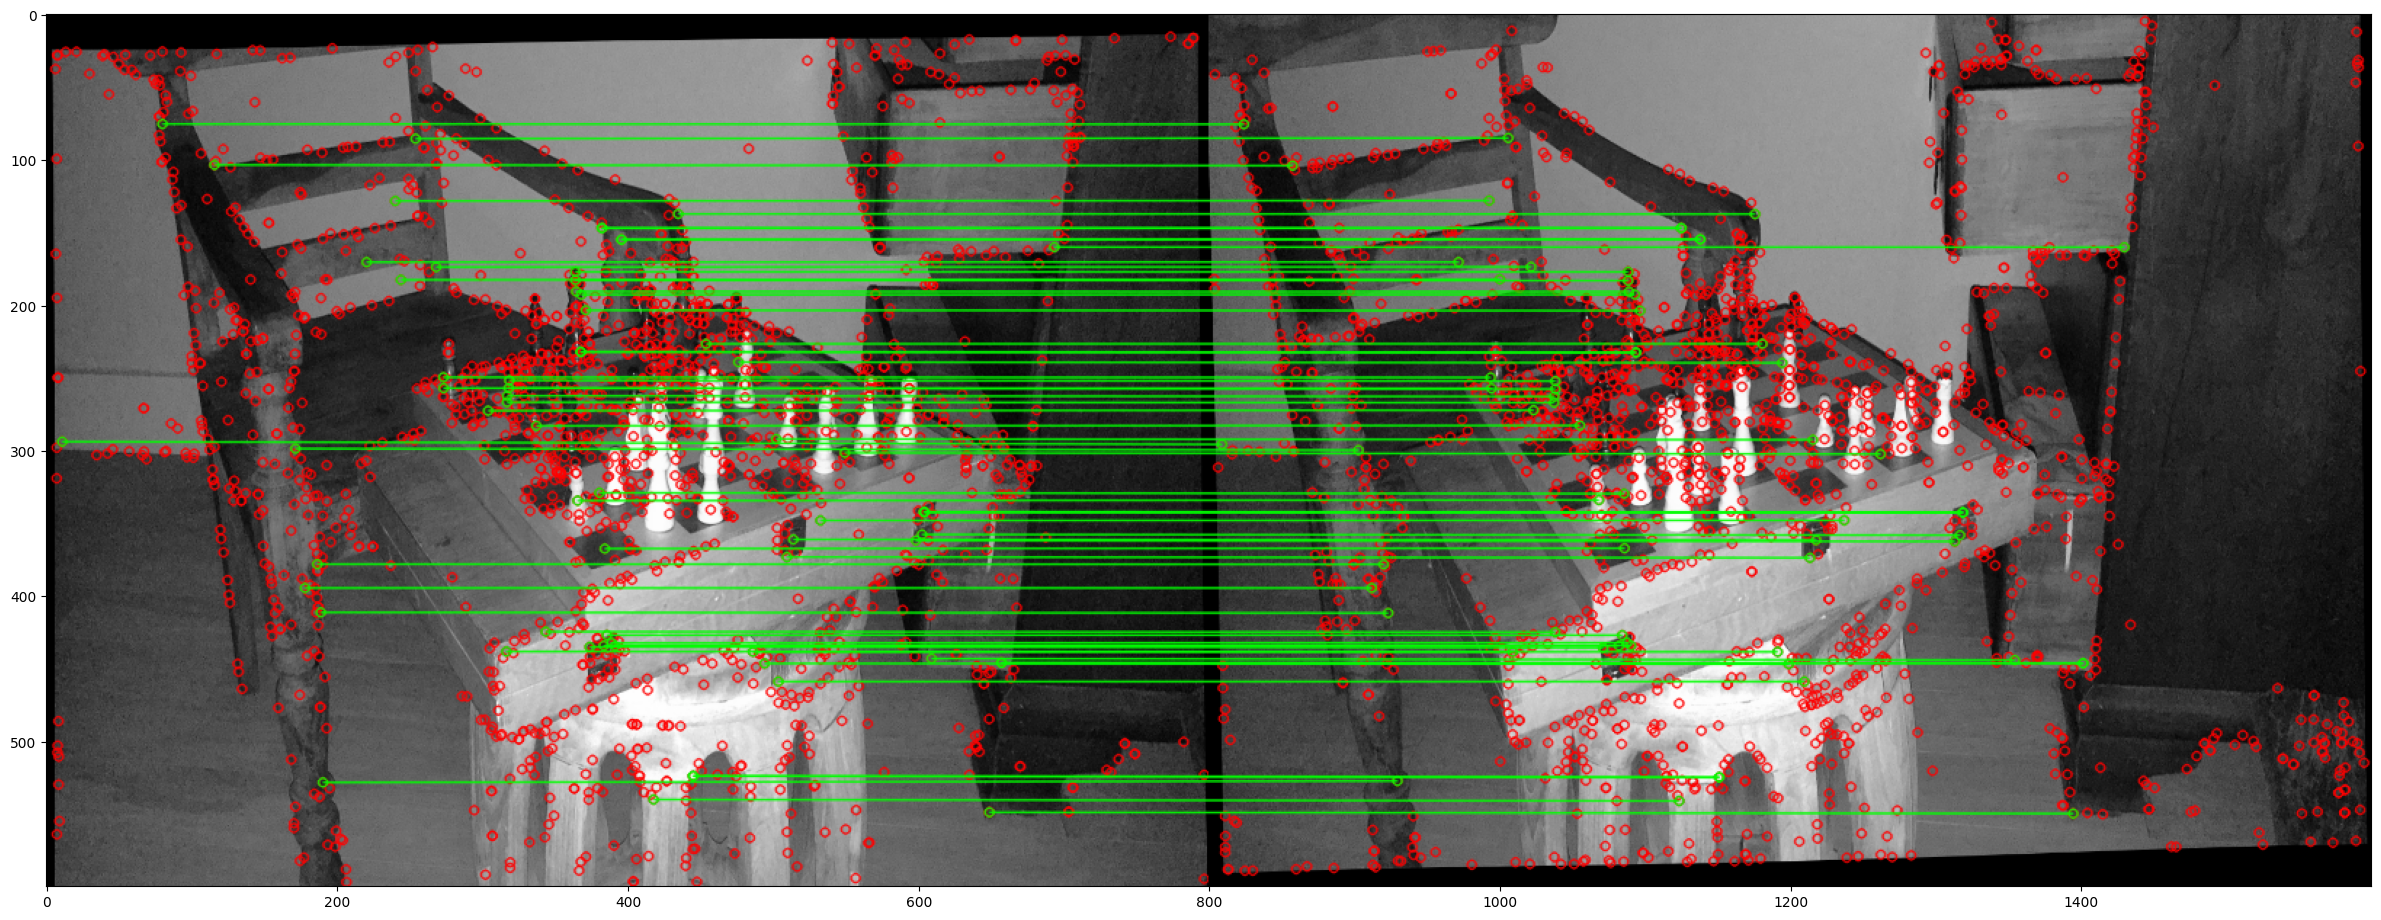

In [14]:
plt.figure(figsize = ( 30, 30))
plt.imshow(result_img)